Iteration 500: sigma_x = 1.083, sigma_y = 1.787, skew = -1.503, acceptance = 0.318
Iteration 1000: sigma_x = 0.943, sigma_y = 1.986, skew = -6.242, acceptance = 0.276
Iteration 1500: sigma_x = 1.223, sigma_y = 1.696, skew = -1.058, acceptance = 0.263
Iteration 2000: sigma_x = 0.946, sigma_y = 1.889, skew = -5.165, acceptance = 0.268
Iteration 2500: sigma_x = 1.078, sigma_y = 2.016, skew = -2.354, acceptance = 0.26
Iteration 3000: sigma_x = 0.993, sigma_y = 2.062, skew = -2.006, acceptance = 0.267
Iteration 3500: sigma_x = 1.086, sigma_y = 2.06, skew = -1.925, acceptance = 0.272
Iteration 4000: sigma_x = 1.133, sigma_y = 1.953, skew = -1.653, acceptance = 0.275
Iteration 4500: sigma_x = 1.007, sigma_y = 2.071, skew = -2.944, acceptance = 0.272
Iteration 5000: sigma_x = 0.929, sigma_y = 2.016, skew = -5.727, acceptance = 0.268
Iteration 5500: sigma_x = 0.912, sigma_y = 2.089, skew = -5.599, acceptance = 0.267
Iteration 6000: sigma_x = 0.936, sigma_y = 2.305, skew = -4.522, acceptance = 0

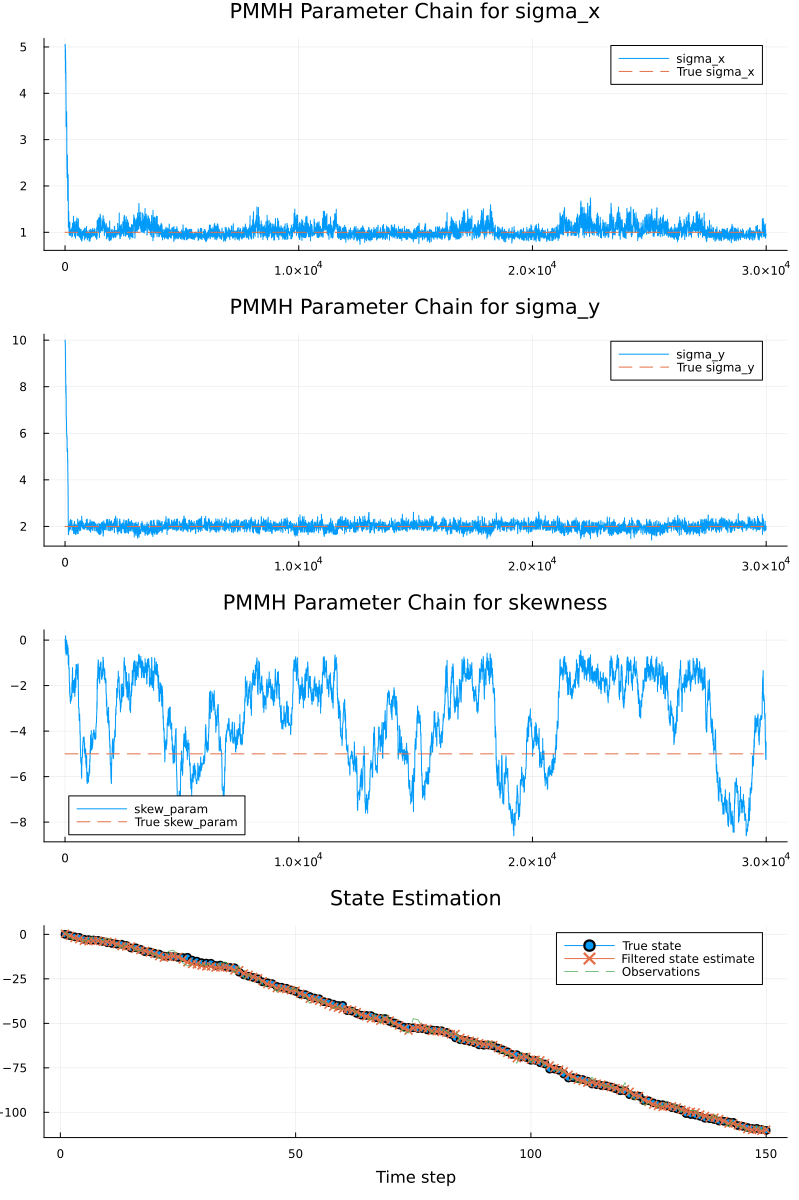

In [1]:
using Random
using Distributions
using StatsBase
using Plots

# ================================
# 1. Generate Synthetic Data with Skewed Process Noise
# ================================

Random.seed!(42)

# True parameters
true_sigma_x = 1.0       # process noise scale (std)
true_sigma_y = 2.0       # observation noise std
true_skew_param = -5.0    # true skewness parameter for process noise
T = 150                  # number of time steps

x_true = zeros(T)
y_obs  = zeros(T)

# Note: Julia uses 1-based indexing.
x_true[1] = 0.0
y_obs[1]  = x_true[1] + rand(Normal(0, true_sigma_y))

for t in 2:T
    # Process noise is skew-normal with true_skew_param.
    # In Julia, SkewNormal(ξ, ω, α) has location ξ, scale ω, and skewness α.
    x_true[t] = x_true[t-1] + rand(SkewNormal(0, true_sigma_x, true_skew_param))
    y_obs[t]  = x_true[t] + rand(Normal(0, true_sigma_y))
end

# ================================
# 2. Particle Filter Function with Skewed Process Noise
# ================================

"""
    particle_filter(y_obs, sigma_x, sigma_y, skew_param; N=500)

Runs a particle filter on the data `y_obs` given model parameters.

Model:
  xₜ = xₜ₋₁ + ε,   ε ~ SkewNormal(0, sigma_x, skew_param)
  yₜ = xₜ + η,     η ~ Normal(0, sigma_y)

Returns a tuple: (log_likelihood, filtered_means)
"""
function particle_filter(y_obs, sigma_x, sigma_y, skew_param; N=500)
    T = length(y_obs)
    particles = zeros(T, N)
    weights = zeros(T, N)
    filtered_means = zeros(T)

    # Initialization: assume x₀ ~ Normal(0, 1)
    particles[1, :] = rand(Normal(0, 1), N)
    # Weight using the Gaussian observation likelihood
    weights[1, :] = [pdf(Normal(p, sigma_y), y_obs[1]) for p in particles[1, :]]
    weight_sum = sum(weights[1, :])
    weights[1, :] ./= weight_sum
    log_likelihood = log(weight_sum / N)
    filtered_means[1] = sum(particles[1, :] .* weights[1, :])

    for t in 2:T
        # Resample indices according to previous weights
        indices = sample(1:N, Weights(weights[t-1, :]), N, replace=true)
        # Resample the previous particles (optional to store the resampled version)
        particles[t-1, :] = particles[t-1, indices]
        # Propagate particles using skew-normal process noise
        particles[t, :] = particles[t-1, :] .+ rand(SkewNormal(0, sigma_x, skew_param), N)
        # Weight using the Gaussian observation likelihood
        weights[t, :] = [pdf(Normal(p, sigma_y), y_obs[t]) for p in particles[t, :]]
        weight_sum = sum(weights[t, :])
        if weight_sum == 0
            weights[t, :] .= 1.0 / N
        else
            weights[t, :] ./= weight_sum
        end
        log_likelihood += log(weight_sum / N)
        filtered_means[t] = sum(particles[t, :] .* weights[t, :])
    end

    return log_likelihood, filtered_means
end

# ================================
# 3. PMMH to Estimate (sigma_x, sigma_y, skew_param)
# ================================

"""
    PMMH(y_obs; n_iter=3000, N=500)

Runs the Particle Marginal Metropolis–Hastings (PMMH) algorithm to estimate
the parameters sigma_x, sigma_y, and skew_param.

Priors:
  sigma_x ~ Exponential(1)   (density ∝ exp(-sigma_x), sigma_x > 0)
  sigma_y ~ Exponential(1)   (density ∝ exp(-sigma_y), sigma_y > 0)
  skew_param ~ Normal(0, 10²)  (density given by pdf(Normal(0, 10), skew_param))

Returns:
  (sigma_x_samples, sigma_y_samples, skew_samples, loglikelihoods)
"""
function PMMH(y_obs; n_iter=3000, N=500)
    sigma_x_samples = zeros(n_iter)
    sigma_y_samples = zeros(n_iter)
    skew_samples    = zeros(n_iter)
    loglikelihoods  = zeros(n_iter)

    # Initialize parameters
    sigma_x_current = 5.0
    sigma_y_current = 10.0
    skew_current    = 0.0  # initial guess for skewness
    ll_current, _ = particle_filter(y_obs, sigma_x_current, sigma_y_current, skew_current; N=N)

    sigma_x_samples[1] = sigma_x_current
    sigma_y_samples[1] = sigma_y_current
    skew_samples[1]    = skew_current
    loglikelihoods[1]  = ll_current

    # Proposal standard deviations for random-walk updates
    prop_std_x   = 0.2
    prop_std_y   = 0.2
    prop_std_skew = 0.2

    accept_count = 0
    for i in 2:n_iter
        # Propose new parameters
        sigma_x_proposal = sigma_x_current + randn() * prop_std_x
        sigma_y_proposal = sigma_y_current + randn() * prop_std_y
        skew_proposal    = skew_current    + randn() * prop_std_skew

        # Reject proposals that are not positive for sigma_x or sigma_y
        if sigma_x_proposal <= 0 || sigma_y_proposal <= 0
            sigma_x_samples[i] = sigma_x_current
            sigma_y_samples[i] = sigma_y_current
            skew_samples[i]    = skew_current
            loglikelihoods[i]  = ll_current
            continue
        end

        # Run particle filter for the proposed parameters
        ll_proposal, _ = particle_filter(y_obs, sigma_x_proposal, sigma_y_proposal, skew_proposal; N=N)

        # Compute log priors:
        # (Note: while the commented Python code suggests using the actual log-priors,
        #  here we follow the provided example and set them to constants.)
        log_prior_current = 1.0
        log_prior_proposal = 1.0

        # Compute the log acceptance ratio
        log_alpha = (ll_proposal + log_prior_proposal) - (ll_current + log_prior_current)
        if log(rand()) < log_alpha
            sigma_x_current = sigma_x_proposal
            sigma_y_current = sigma_y_proposal
            skew_current    = skew_proposal
            ll_current      = ll_proposal
            accept_count   += 1
        end

        sigma_x_samples[i] = sigma_x_current
        sigma_y_samples[i] = sigma_y_current
        skew_samples[i]    = skew_current
        loglikelihoods[i]  = ll_current

        if mod(i, 500) == 0
            println("Iteration $i: sigma_x = $(round(sigma_x_current, digits=3)), sigma_y = $(round(sigma_y_current, digits=3)), skew = $(round(skew_current, digits=3)), acceptance = $(round(accept_count/i, digits=3))")
        end
    end

    println("Final acceptance rate: $(round(accept_count/n_iter, digits=3))")
    return sigma_x_samples, sigma_y_samples, skew_samples, loglikelihoods
end

# Run PMMH
n_iter = 30000
sigma_x_chain, sigma_y_chain, skew_chain, ll_chain = PMMH(y_obs; n_iter=n_iter, N=2000)

# Discard burn-in (e.g., first 5000 iterations)
burn_in = 20000
est_sigma_x = mean(sigma_x_chain[burn_in+1:end])
est_sigma_y = mean(sigma_y_chain[burn_in+1:end])
est_skew    = mean(skew_chain[burn_in+1:end])

println("Estimated sigma_x: $(round(est_sigma_x, digits=3)) (true: $(true_sigma_x))")
println("Estimated sigma_y: $(round(est_sigma_y, digits=3)) (true: $(true_sigma_y))")
println("Estimated skew:    $(round(est_skew, digits=3)) (true: $(true_skew_param))")

# ================================
# 4. Obtain State Estimates using the Filter
# ================================
ll_final, state_estimates = particle_filter(y_obs, est_sigma_x, est_sigma_y, est_skew; N=2000)

# ================================
# 5. Plotting the Results
# ================================

# Plot parameter chains
p1 = plot(sigma_x_chain, label="sigma_x", title="PMMH Parameter Chain for sigma_x")
plot!(p1, fill(true_sigma_x, length(sigma_x_chain)), label="True sigma_x", linestyle=:dash)

p2 = plot(sigma_y_chain, label="sigma_y", title="PMMH Parameter Chain for sigma_y")
plot!(p2, fill(true_sigma_y, length(sigma_y_chain)), label="True sigma_y", linestyle=:dash)

p3 = plot(skew_chain, label="skew_param", title="PMMH Parameter Chain for skewness")
plot!(p3, fill(true_skew_param, length(skew_chain)), label="True skew_param", linestyle=:dash)

# Plot state estimates vs. true state and observations
time = 1:T
p4 = plot(time, x_true, label="True state", marker=:circle, title="State Estimation", xlabel="Time step")
plot!(p4, time, state_estimates, label="Filtered state estimate", marker=:x)
plot!(p4, time, y_obs, label="Observations", linestyle=:dash, alpha=0.7)

plot(p1, p2, p3, p4, layout=(4, 1), size=(800, 1200))
